In [1]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp # imports a statistical programming library
import matplotlib as mpl # imports the standard plotting library
import matplotlib.cm as cm # imports plotting colormaps
import matplotlib.pyplot as plt # imports the MATLAB compatible plotting API
import pandas as pd # imports a library to handle data as dataframes
import seaborn.apionly as sns

//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
//anaconda/envs/py3l/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [21]:
df = pd.read_csv("data/ratings.csv.gz", compression='gzip')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [22]:
df.drop("timestamp",inplace=True, axis=1)
df.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [23]:
df.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [24]:
df2 = df.sample(50000)

In [25]:
df2.userId = df2.userId.astype('category').cat.codes.values
df2.movieId = df2.movieId.astype('category').cat.codes.values

In [26]:
n_ratings = df2.shape[0]
n_ratings

50000

In [27]:
n_factors=3
n_users, n_movies = len(df2.userId.unique()), len(df2.movieId.unique())
n_users, n_movies

(33243, 6594)

In [28]:
df2.head()

,userId,movieId,rating
2703571,4539,1492,2.5
12887545,21449,1147,4.0
16996832,28335,823,3.0
905459,1545,775,4.5
845713,1439,178,3.0


In [29]:
np.random.seed=2017
mask = np.random.rand(50000) < 0.8

In [30]:
traindf = df2[mask]
testdf = df2[~mask]

In [36]:
import keras
movie_input = keras.layers.Input(shape=[1],name='movieId')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_factors, name='movieEmbedding')(movie_input)
movie_vec = keras.layers.Flatten(name='movieFlatten')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='userId')
user_embedding = keras.layers.Embedding(n_users + 1, n_factors,name='userEmbedding')(user_input)
user_vec = keras.layers.Flatten(name='userFlatten')(user_embedding)

prod = keras.layers.Dot(axes=1, name="MatrixFactorization")([movie_vec, user_vec] )
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mse')

In [37]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movieId (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
userId (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
movieEmbedding (Embedding)      (None, 1, 3)         19785       movieId[0][0]                    
__________________________________________________________________________________________________
userEmbedding (Embedding)       (None, 1, 3)         99732       userId[0][0]                     
__________________________________________________________________________________________________
movieFlatt

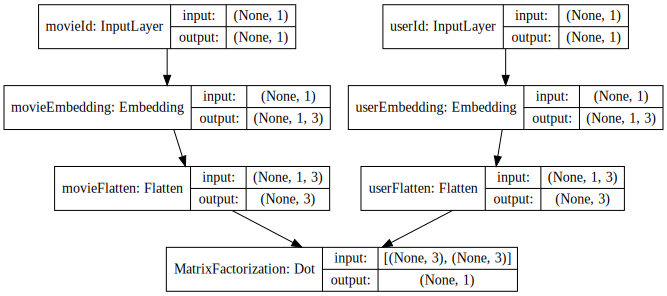

In [45]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [39]:
traindf.userId.values

array([ 4539, 21449, 28335, ..., 26948,  1766, 31200], dtype=int32)

In [40]:
history = model.fit([traindf.userId.values, traindf.movieId.values], traindf.rating.values, epochs=100)

Epoch 1/100
40102/40102 [==============================] - 10s 240us/step - loss: 13.5493
Epoch 2/100
40102/40102 [==============================] - 9s 227us/step - loss: 13.5154
Epoch 3/100
40102/40102 [==============================] - 9s 237us/step - loss: 13.3653
Epoch 4/100
40102/40102 [==============================] - 10s 250us/step - loss: 13.0370
Epoch 5/100
40102/40102 [==============================] - 10s 243us/step - loss: 12.5399
Epoch 6/100
40102/40102 [==============================] - 10s 246us/step - loss: 11.9038
Epoch 7/100
40102/40102 [==============================] - 12s 289us/step - loss: 11.1570
Epoch 8/100
40102/40102 [==============================] - 10s 240us/step - loss: 10.3298
Epoch 9/100
40102/40102 [==============================] - 9s 225us/step - loss: 9.4517
Epoch 10/100
40102/40102 [==============================] - 9s 223us/step - loss: 8.5550
Epoch 11/100
40102/40102 [==============================] - 11s 264us/step - loss: 7.6719
Epoch 12/100
40

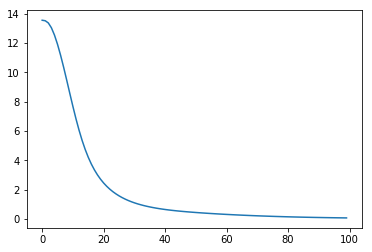

In [41]:
plt.plot(history.history['loss'])

In [44]:
y_hat = model.predict([testdf.userId.values, testdf.movieId.values])
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(testdf.rating.values, y_hat))

4.2566359948675405